In [26]:
import torch
import numpy as np
import meshzoo
from math import sqrt
import matplotlib.pyplot as plt

from torchfem.elements import linear_to_quadratic
from torchfem import Planar
from torchfem.materials import IsotropicPlaneStress
from torchfem.io import import_mesh
from torchfem.examples import get_example_file

# Set double precision
torch.set_default_dtype(torch.float64)

# Material model (plane stress)
material = IsotropicPlaneStress(E=1000.0, nu=0.3)

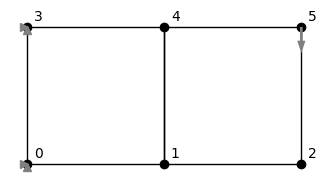

In [27]:
nodes = 0.2 * torch.tensor(
    [[0.0, 0.0], [1.0, 0.0], [2.0, 0.0], [0.0, 1.0], [1.0, 1.0], [2.0, 1.0]]
)
elements = torch.tensor([[0, 1, 4, 3], [1, 2, 5, 4]])

# Load at tip
tip = (nodes[:, 0] == 0.2 * 2.0) & (nodes[:, 1] == 0.2 * 1.0)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Create model
cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)

cantilever.plot(node_markers="o", node_labels=True, figsize=(4, 2))

## A simple cantilever beam with first order quads

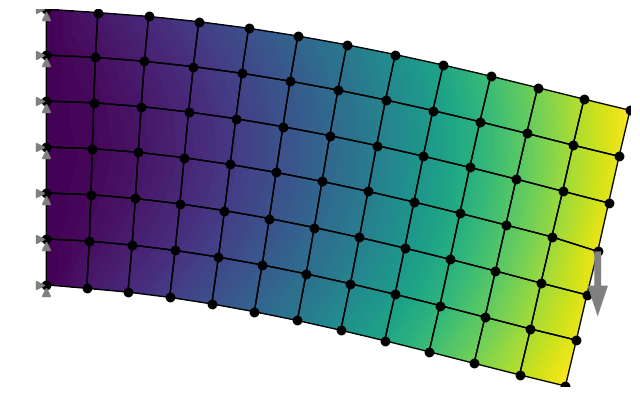

In [28]:
points, cells = meshzoo.rectangle_quad(
    np.linspace(0.0, 2.0, 13),
    np.linspace(0.0, 1.0, 7),
    cell_type="quad4",
)
nodes = torch.tensor(points, dtype=torch.get_default_dtype())
elements = torch.tensor(cells.tolist())

# Load at tip
tip = (nodes[:, 0] == 2.0) & (nodes[:, 1] == 0.5)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Create model
cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)

# Solve
u, f = cantilever.solve()

# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1), node_markers=True)

## A simple cantilever beam with second order quads

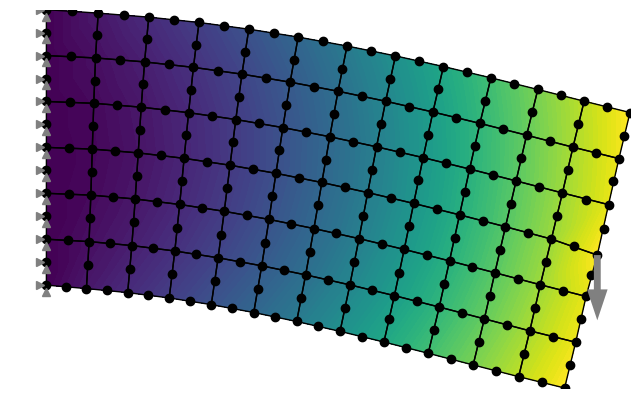

In [29]:
# Upgrade elements to quadratic
nodes, elements = linear_to_quadratic(nodes, elements)

# Load at tip
tip = (nodes[:, 0] == 2.0) & (nodes[:, 1] == 0.5)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Create model
cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)

# Solve
u, f = cantilever.solve()

# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1), node_markers=True)

## A simple cantilever beam with first order triangles 

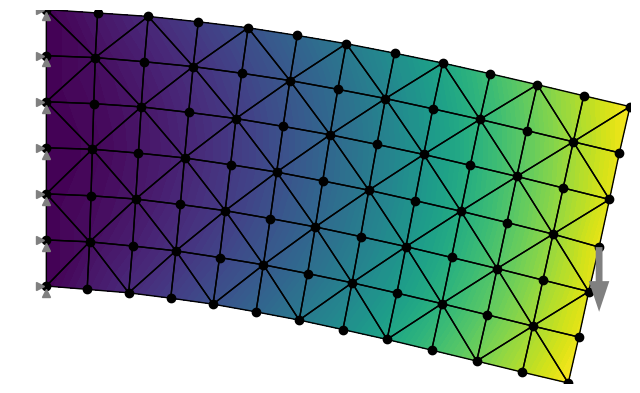

In [30]:
points, cells = meshzoo.rectangle_tri(
    np.linspace(0.0, 2.0, 13),
    np.linspace(0.0, 1.0, 7),
    variant="zigzag",
)
nodes = torch.tensor(points, dtype=torch.get_default_dtype())
elements = torch.tensor(cells.tolist())

# Load at tip
tip = (nodes[:, 0] == 2.0) & (nodes[:, 1] == 0.5)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)
# Solve
u, f = cantilever.solve()
# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1), node_markers=True)

## A simple cantilever beam with second order triangles 

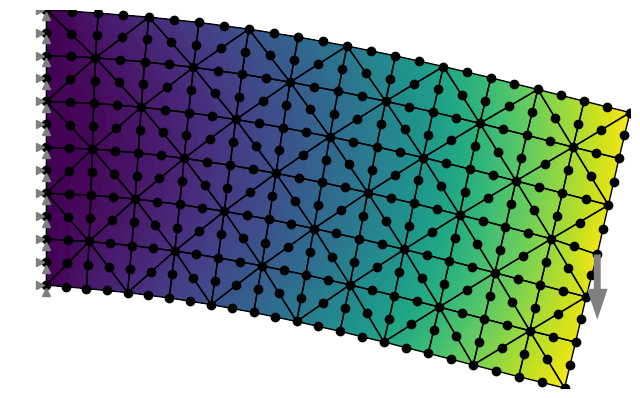

In [31]:
# Upgrade elements to quadratic
nodes, elements = linear_to_quadratic(nodes, elements)

# Load at tip
tip = (nodes[:, 0] == 2.0) & (nodes[:, 1] == 0.5)
forces = torch.zeros_like(nodes)
forces[tip, 1] = -1.0

# Constrained displacement at left end
left = nodes[:, 0] == 0.0
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

# Create model
cantilever = Planar(
    nodes, elements, forces, displacements, constraints, thickness, material.C()
)
# Solve
u, f = cantilever.solve()

# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1), node_markers=True)

## A simple fillet in 2D 

In [32]:
# Import mesh
specimen = import_mesh(get_example_file("fillet.vtu"), C=material.C())

# Symmetry nodes
left = specimen.nodes[:, 0] < 0.1
specimen.constraints[left, 0] = True
bottom = specimen.nodes[:, 1] < 0.1
specimen.constraints[bottom, 1] = True

# Load at right end
right = specimen.nodes[:, 0] >= specimen.nodes[:, 0].max() - 0.1
specimen.constraints[right, 0] = True
specimen.displacements[right, 0] = 6.0

In [33]:
u, f = specimen.solve()

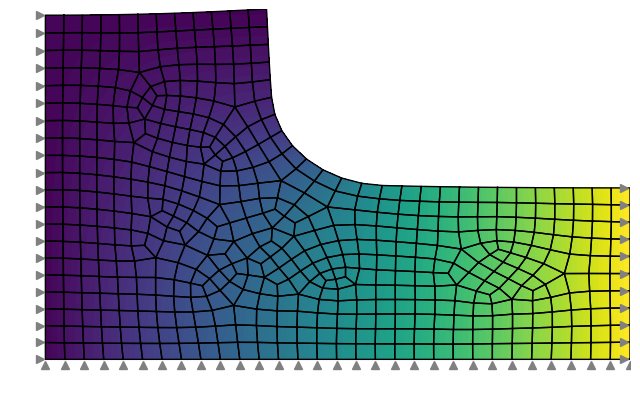

In [34]:
specimen.plot(u, node_property=u[:, 0], figsize=(8, 8))

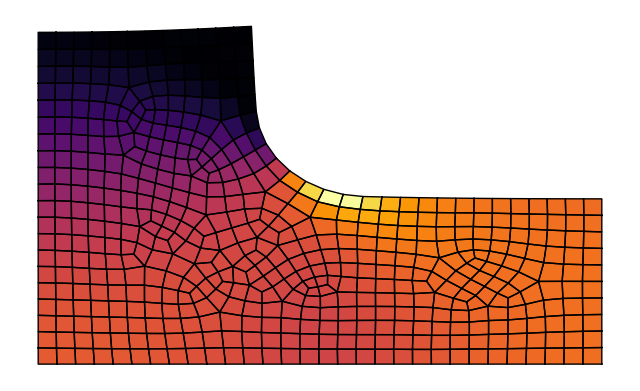

In [35]:
# Stress
mises = specimen.compute_stress(u, mises=True)
specimen.plot(u, bcs=False, element_property=mises, figsize=(8, 8), cmap="inferno")

## Plasticity

We implement a plane stress projected von Mises model with isotropic hardening for a simple plate with a hole. 



#### Material properties 
The elastic material is plane stress isotropic elasticity. The plastic hardening is modeled as a linear hardening function given by

$$
\sigma_f(q) = \sigma_y + k q
$$

with the yield stress $\sigma_y$, the equivalent plastic strain $q$ and the hardening modulus $k$.

In [36]:
# Material properties
E = 1000.0
nu = 0.3
sigma_y = 10.0
k = 10.0

# Elastic properties
material = IsotropicPlaneStress(E=E, nu=nu)
C = material.C()
S = torch.linalg.inv(C)
G = material.G()
E = material.E()
nu = material.nu()


# Hardening function
def sigma_f(q):
    return sigma_y + k * q


# Derivative of the hardening function
def sigma_f_prime(q):
    return k

#### Geometry 
The geometry is a plate with a hole, imported from the example files. It is fully clamped on the left hand side and subjected to a line fore on the right hand side, which is applied in 20 increments. One of the first elements to yield is element 405, which is highlighted black in the following plot.

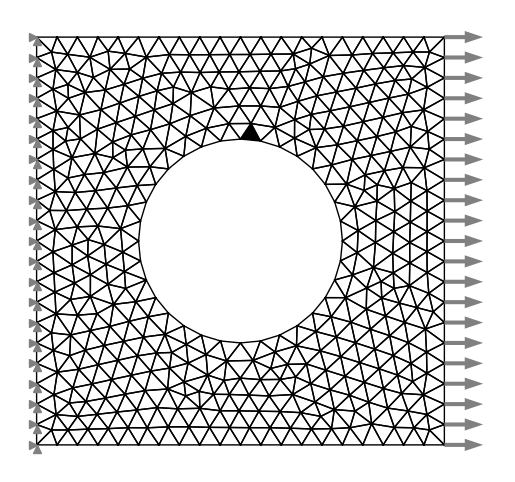

In [37]:
# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

# Applied load
load = 5.0

# Load increments
N = 20

# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), C=C)
plate.thickness = t * torch.ones(len(plate.elements))

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
force_increment = load * L * t / N
weigths = 2.0 * torch.ones(right.sum())
weigths[0] = 1.0
weigths[1] = 1.0
plate.forces[right, 0] = force_increment * weigths / weigths.sum()

# Indicator function to highlight the element for later comparison
indicator = torch.zeros(len(plate.elements))
indicator[405] = 1.0

plate.plot(element_property=indicator, cmap="gray_r")

#### Newton-Raphson return-mapping algorithm 

The planar stress plasticity problem is actually a bit more tricky than the 3D problem, because stress states have to be projected to the planar state. This implementation follows de Souza Neto et al., specifically the algorithms lined out in Box 9.3 to Box 9.6 [1].

In each step, we compute a trial stress 
$$ 
\sigma_{\text{trial}} = \sigma_n + C : \Delta\varepsilon
$$
and check if it exceeds the yield surface by evaluating the squared flow potential
$$ 
\psi = \frac{1}{2}\sigma_{\text{trial}}^\top P \sigma_{\text{trial}} - \frac{1}{3} \sqrt{\frac{2}{3}}\sigma_f(q)^2 
\quad \text{with} \quad P = \frac{1}{3}\begin{bmatrix} 2 & -1 & 0 \\ -1 & 2 & 0 \\ 0 & 0 & 6 \end{bmatrix}.
$$


1. If $\psi \leq 0$, the stress state is elastic. We update the variables as follows: 
   $$
   \sigma_{n+1} = \sigma_{\text{trial}} \\ q_{n+1} = q_{n}\\ d\sigma d\varepsilon_{n+1} = C.
   $$

2. If $\psi > 0$, the stress state is plastic. We need to calculate the equivalent plastic strain $\Delta \gamma$ that leads to $\psi=0$ to satisfy the yield condition. This is a nonlinear equation and we solve it with a Newton-Raphson algorithm. We start with $\Delta \gamma=0$ and compute in each iteration the residual
   $$
   \xi = \frac{(\sigma_{11}^{\text{trial}} + \sigma_{22}^{\text{trial}})^2 }{6 (1 + \frac{E  \Delta \gamma }{3(1 - \nu)})^2}
      + \frac{\frac{1}{2}(\sigma_{22}^{\text{trial}} - \sigma_{11}^{\text{trial}})^2 + 2 (\sigma_{12}^{\text{trial}})^2 }{(1 + 2  G  \Delta \gamma)^2}\\
   q = q_n + \sqrt{\frac{2}{3} \xi} \Delta \gamma\\
   \psi = \frac{1}{2} \xi - \frac{1}{3} \sigma_f(q)^2
   $$
   and its derivative
   $$
   H = \sigma_f'(q)\\
   \xi' = -\frac{(\sigma_{11}^{\text{trial}} + \sigma_{22}^{\text{trial}})^2 }{9 (1 + \frac{E  \Delta \gamma }{3(1 - \nu)})^3} \frac{E}{1 - \nu}
      - 2 G \frac{(\sigma_{22}^{\text{trial}} - \sigma_{11}^{\text{trial}})^2 + 4 (\sigma_{12}^{\text{trial}})^2 }{(1 + 2  G  \Delta \gamma)^3}\\
   H' = 2 \sigma_f(q) H \sqrt(\frac{2}{3}) (\sqrt{\xi} + \frac{\Delta \gamma \xi' }{2 * \sqrt{\xi}})
   \psi' = \frac{1}{2} \xi' - \frac{1}{3} H'
   $$
   to update $\Delta \gamma$ according to
   $$
   \Delta \gamma = \Delta \gamma - \frac{\psi}{\psi'}
   $$
   until $\psi$ is sufficiently small. Then, we update the variables as follows
   $$
   \sigma_{n+1} = I C \sigma_{\text{trial}} \\ q_{n+1} = q\\ d\sigma d\varepsilon_{n+1} = I - \alpha n \otimes n.
   $$
   with 
   $$
   I = [C+\Delta \gamma P ]^{-1}\\
   n = I P  \sigma_{n+1}\\
   \alpha = \frac{1}{ \sigma_{n+1}^\top P  \sigma_{n+1} + \frac{2\xi H}{3- 2 H \Delta \gamma}}.
   $$

[1] de Souza Neto, E. A., Peri, D., Owen, D. R. J. *Computational Methods for Plasticity*, Chapter 9: Plane Stress Plasticity, https://doi.org/10.1002/9780470694626.ch9, 2008.



In [38]:
P = 1 / 3 * torch.tensor([[2, -1, 0], [-1, 2, 0], [0, 0, 6]])


# Initialize variables
n_elem = len(plate.elements)
u = torch.zeros_like(plate.nodes)
epsilon = torch.zeros((n_elem, 3))
sigma = torch.zeros((n_elem, 3))
q = torch.zeros((n_elem))


stress = [0.0]
strain = [0.0]
peeq = [0.0]

for i in range(N):
    # Solve small deformation increment
    du, df = plate.solve()

    # Strain increment
    de = plate.compute_strain(du)
    epsilon += de

    # Compute trial stress
    ds = torch.einsum("...ij,...j->...i", C, de)
    s_trial = sigma + ds

    # Flow potential
    a1 = (s_trial[:, 0] + s_trial[:, 1]) ** 2
    a2 = (s_trial[:, 1] - s_trial[:, 0]) ** 2
    a3 = s_trial[:, 2] ** 2
    xi_trial = 1 / 6 * a1 + 1 / 2 * a2 + 2 * a3
    psi = 1 / 2 * xi_trial - 1 / 3 * sigma_f(q) ** 2

    # Flow mask
    fm = psi > 0

    # Newton solver to find plastic strain increment
    dGamma = torch.zeros_like(psi[fm])
    for j in range(10):
        # Compute xi and some short hands
        xi = (
            a1[fm] / (6 * (1 + E * dGamma / (3 * (1 - nu))) ** 2)
            + (1 / 2 * a2[fm] + 2 * a3[fm]) / (1 + 2 * G * dGamma) ** 2
        )
        sxi = torch.sqrt(xi)
        qq = q[fm] + dGamma * torch.sqrt(2 / 3 * xi)

        # Compute residual
        res = 1 / 2 * xi - 1 / 3 * sigma_f(qq) ** 2

        # Compute derivative of residual w.r.t dGamma
        H = sigma_f_prime(qq)
        xi_p = (
            -a1[fm] / (9 * (1 + E * dGamma / (3 * (1 - nu))) ** 3) * E / (1 - nu)
            - 2 * G * (a2[fm] + 4 * a3[fm]) / (1 + 2 * G * dGamma) ** 3
        )
        H_p = 2 * sigma_f(qq) * H * sqrt(2 / 3) * (sxi + dGamma * xi_p / (2 * sxi))
        res_prime = 1 / 2 * xi_p - 1 / 3 * H_p

        # Update dGamma
        dGamma -= res / res_prime

    if (torch.abs(res) > 1e-10).any():
        print("Local Newton iteration did not converge")

    # Compute inverse operator
    inv = torch.linalg.inv(S + dGamma[:, None, None] * P)

    # Update stress
    sigma[~fm] = s_trial[~fm]
    sigma[fm] = (inv @ S @ s_trial[fm][:, :, None]).squeeze(-1)

    # Update plastic strain
    q[fm] = qq

    # Update algorithmic tangent
    plate.C[~fm] = C
    xi = sigma[fm][:, :, None].transpose(-1, -2) @ P @ sigma[fm][:, :, None]
    H = sigma_f_prime(q[fm])
    n = inv @ P @ sigma[fm][:, :, None]
    alpha = 1 / (
        sigma[fm][:, :, None].transpose(-1, -2) @ P @ n
        + 2 * xi * H / (3 - 2 * H * dGamma[:, None, None])
    )
    plate.C[fm] = inv - alpha * n @ n.transpose(-1, -2)

    # Update displacement
    u += du

    # Store data of most critical element
    stress.append(sigma[405, 0].item())
    strain.append(epsilon[405, 0].item())
    peeq.append(q[405].item())

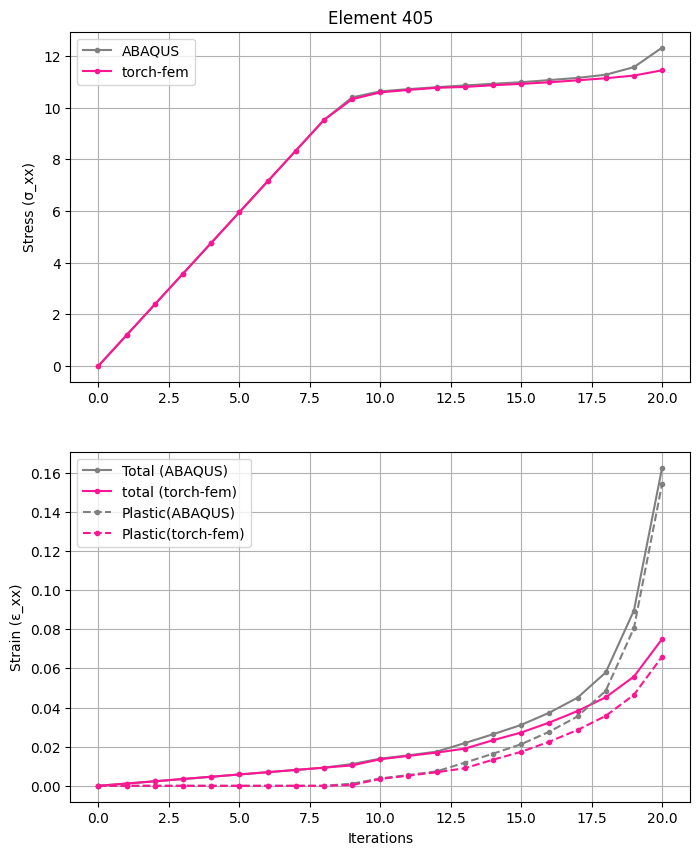

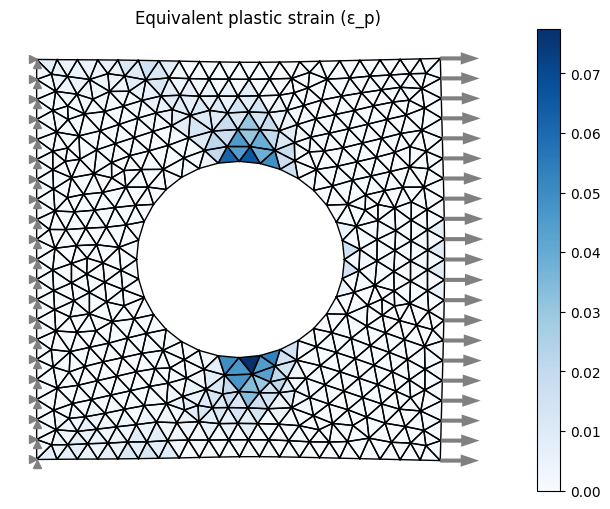

In [39]:
ref_data = np.array(
    [
        [0, 0, 0.00000],
        [0.00115863, 0, 1.18972],
        [0.00231726, 0, 2.37944],
        [0.00347588, 0, 3.56916],
        [0.00463451, 0, 4.75888],
        [0.00579314, 0, 5.94860],
        [0.00695177, 0, 7.13832],
        [0.00811039, 0, 8.32804],
        [0.00926902, 0, 9.51776],
        [0.0111287, 0.00109242, 10.3928],
        [0.0138697, 0.00378789, 10.6270],
        [0.0155667, 0.00548699, 10.7136],
        [0.0174585, 0.007391, 10.7888],
        [0.0218321, 0.0118273, 10.8568],
        [0.0263462, 0.0164109, 10.9203],
        [0.0311143, 0.0212644, 10.9806],
        [0.0373726, 0.0276408, 11.0636],
        [0.0450277, 0.0354477, 11.1487],
        [0.057917, 0.0485668, 11.2713],
        [0.0895547, 0.0805989, 11.5656],
        [0.162536, 0.154277, 12.3205],
    ]
)


fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(ref_data[:, 2], ".-", color="gray", label="ABAQUS")
ax[0].plot(stress, ".-", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()

ax[1].plot(ref_data[:, 0], ".-", color="gray", label="Total (ABAQUS)")
ax[1].plot(strain, ".-", color="deeppink", label="total (torch-fem)")
ax[1].plot(ref_data[:, 1], ".--", color="gray", label="Plastic(ABAQUS)")
ax[1].plot(peeq, ".--", color="deeppink", label="Plastic(torch-fem)")
ax[1].grid()
ax[1].set_ylabel("Strain (ε_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")
plt.show()

plate.plot(
    u=u,
    element_property=q,
    cmap="Blues",
    colorbar=True,
    title="Equivalent plastic strain (ε_p)",
)